# Model building - Classification

### ressources:
* [article about cost-sensitive regression](https://machinelearningmastery.com/cost-sensitive-logistic-regression/)
* [article Bagging and Random Forest for Inbalanced Classification](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/#:~:text=Bagging%20is%20an%20ensemble%20algorithm,used%20in%20each%20data%20sample.)
* [article about metrics for classification problems](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234#:~:text=Area%20Under%20Curve(AUC)%20is,a%20randomly%20chosen%20negative%20example.)
* [article : Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
* [article : ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/model_nobel.csv', index_col='Author_clean' )

In [4]:
data.head()

,nb_downl,nb_pages,Students,nb_works,h_index,nb_cit,vn_award,clark,nobel,top10_shangai_yn,usa_yn,descri_len,len_work
Author_clean,,,,,,,,,,,,,
Christopher F,7515,1099,10.0,415,21,3062,0,0,0,0,1,12.0,3.0
Daron Acemoglu,6537,5349,23.0,645,72,24703,1,1,0,1,1,12.0,8.0
Joseph E. Stiglitz,6290,5753,6.0,643,72,25947,0,1,1,1,1,19.0,9.0
John List,5632,3642,5.0,681,56,11165,0,0,0,1,1,11.0,5.0
Robert J. Barro,5426,2705,7.0,329,65,31421,0,0,0,1,1,11.0,8.0


In [5]:
data.shape

(399, 13)

In [6]:
X = data.drop('nobel', axis=1)
y = data['nobel']

In [7]:
from sklearn.model_selection import train_test_split

In [21]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = 0.3)

In [22]:
y_train.value_counts()

0    258
1     21
Name: nobel, dtype: int64

In [23]:
y_test.value_counts()

0    111
1      9
Name: nobel, dtype: int64

In [24]:
print('prop nobel in train set', round(24/(295+24), 3))
print('prop nobel in test set', round(6/(80), 3))

prop nobel in train set 0.075
prop nobel in test set 0.075


In [100]:
# logistic regression
    # a. without cost-sensitive
    
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

log_r = LogisticRegression(solver='liblinear')
cv = StratifiedKFold(n_splits=2)
scores = cross_val_score(log_r, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.770


In [101]:
    #b. with cost-sensitive tuning
        # default class weighting
log_cs = LogisticRegression(solver='liblinear', class_weight='balanced')
cv = StratifiedKFold(n_splits=2)
scores = cross_val_score(log_cs, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.783


In [55]:
        # using grid search  to possibly find a better weighting 
from sklearn.model_selection import GridSearchCV
balance = [{0: 1,1:20}, {0:1,1:30}, {0:1,1:12}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = StratifiedKFold(n_splits=2)
# define grid search
grid = GridSearchCV(estimator=log_cs, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.786857 using {'class_weight': {0: 1, 1: 10}}
0.783051 (0.106307) with: {'class_weight': {0: 1, 1: 20}}
0.783228 (0.110359) with: {'class_weight': {0: 1, 1: 30}}
0.786011 (0.098414) with: {'class_weight': {0: 1, 1: 12}}
0.786857 (0.096159) with: {'class_weight': {0: 1, 1: 10}}
0.777801 (0.108034) with: {'class_weight': {0: 1, 1: 100}}


In [103]:
        # optimized cost sensitive logistic regression
weights = {0:1, 1:10}
log_opt = LogisticRegression(solver='liblinear', class_weight=weights)
cv = StratifiedKFold(n_splits=2)
scores = cross_val_score(log_opt, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.4f' % np.mean(scores))

Mean ROC AUC: 0.7869


In [126]:
log_opt.fit(X_train, y_train)
pred_train = log_opt.predict(X_train)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, pred_train)

array([[215,  43],
       [  4,  17]], dtype=int64)

In [127]:
score = log_opt.score(X_train, y_train)
print('Classic performance evaluation, proportion of guesses right:', score)

Classic performance evaluation, proportion of guesses right: 0.8315412186379928


In [117]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, )
neigh.fit(X_train, y_train)
cv = StratifiedKFold(n_splits=3)
scores = cross_val_score(neigh, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.602


In [162]:
# Random Forest classifier
    # cost-sensitive tuning
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, class_weight='balanced')
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(rfc, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.841


In [163]:
    # parameter tuning 
parameters = {'n_estimators':range(10,300,10), 'criterion':('gini','entropy'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rfc,parameters,scoring='roc_auc',cv=cv)
gs.fit(X_train,y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

Best: 0.850085 using {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 60}


In [168]:
    # random forrest classifier optimized
rfc = RandomForestClassifier(n_estimators=60, criterion='gini', max_features='auto', random_state=0, class_weight='balanced')
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(rfc, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.850


In [174]:
    # random forest with random undersampling
from imblearn.ensemble import BalancedRandomForestClassifier
rfus = BalancedRandomForestClassifier(random_state=0, class_weight='balanced')
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(rfus, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.795


In [175]:
    # parameter tuning 
parameters = {'n_estimators':range(10,300,10), 'criterion':('gini','entropy'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rfus,parameters,scoring='roc_auc',cv=cv)
gs.fit(X_train,y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

Best: 0.830298 using {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 280}


In [184]:
    # random forest with random undersampling (optimized)
from imblearn.ensemble import BalancedRandomForestClassifier
rfus = BalancedRandomForestClassifier(n_estimators=280,
                                       random_state=0, class_weight='balanced', criterion='entropy', max_features='auto')
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(rfus, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs= -1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.830


In [185]:
# test 3 models on test set
# 1. logisitic regression cost-sensitive
# 2. KNN classfier
# 3. Random forest classifier
rfc.fit(X_train, y_train)
rfus.fit(X_train, y_train)
tpred_log = log_opt.predict(X_test)
tpred_knn = neigh.predict(X_test)
tpred_rf = rfc.predict(X_test)
tpred_rfus = rfus.predict(X_test)


Confusion matrix, cost-sensitive logisitic regression
[[90 21]
 [ 2  7]]
Confusion matrix, KNN classifier
[[111   0]
 [  9   0]]
Confusion matrix, Random forst classifier
[[111   0]
 [  8   1]]
Confusion matrix, RF w/ Random undersampling
[[91 20]
 [ 1  8]]
Confusion matrix, RF w/ Random undersampling Normalized
[[0.81981982 0.18018018]
 [0.11111111 0.88888889]]


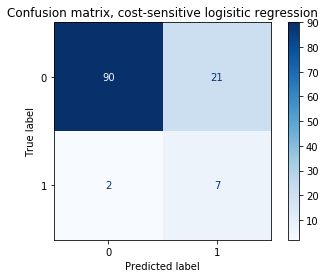

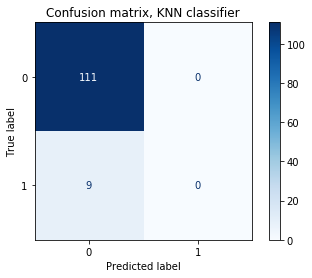

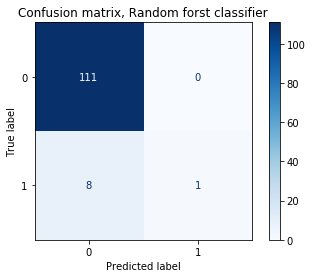

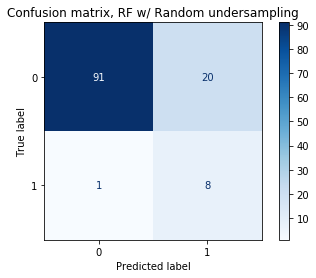

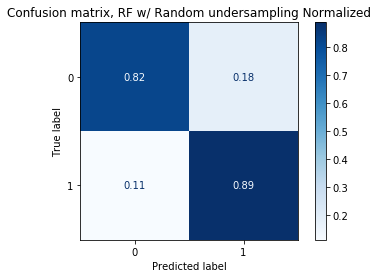

In [191]:
# confusion matrices
from sklearn.metrics import plot_confusion_matrix
classifiers = [log_opt, neigh, rfc]
titles_options = [("Confusion matrix, cost-sensitive logisitic regression", None, log_opt),
                  ("Confusion matrix, KNN classifier", None, neigh),
                  ("Confusion matrix, Random forst classifier", None, rfc),
                  ("Confusion matrix, RF w/ Random undersampling", None, rfus),
                  ("Confusion matrix, RF w/ Random undersampling Normalized", 'true', rfus)]

for title, normalize, classifier in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. 

**Here the model which generalize the best if our Random forest w/ random undersampling**

Let's evaluate this model with precise metrics

In [208]:
# first get the probabilities predicited on the test set by the rfus model
# predict probabilities
ppred_rfus = rfus.predict_proba(X_test)
# predicitions for the positiv class
pos_ppred = ppred_rfus[:, 1]

In [189]:
# Accuracy score of our rfus model
print('Accuracy score, derived from the confusion matrix of rfus model :', (91 + 8)/120)

Accuracy score, derived from the confusion matrix of rfus model : 0.825


In [209]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, pos_ppred)
print('AUC score of rfus model :', round(auc_score,3))

AUC score of rfus model : 0.934


In [212]:
# Precision-Recall Area Under Curve (AUC) Score (less optimistic thant ROC)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(y_test, pos_ppred)
auc_score = auc(recall, precision, )
auc_score

0.5073105906439239

No Skill PR AUC: 0.139


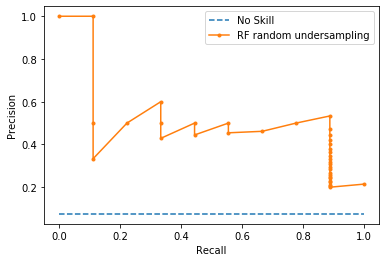

In [220]:
# compare to a naive classifier
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot

model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    # calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(test_y, model_probs)
	pyplot.plot(recall, precision, marker='.', label='RF random undersampling')
	# axis labels
	pyplot.xlabel('Recall')
	pyplot.ylabel('Precision')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
plot_pr_curve(y_test, pos_ppred)

In [195]:
# F1 score 

F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

> Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.
> Maximizing precision will minimize the false-positive errors, whereas maximizing recall will minimize the false-negative errors.

In [204]:
    # precision = sensitivity (how well the positive class was predicted)
    # recall = TruePositive / (TruePositive + FalseNegative) = sensitivity

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print(precision_score(y_test, tpred_rfus))
print(recall_score(y_test, tpred_rfus))
from sklearn.metrics import f1_score
f1_score(y_test, tpred_rfus, average='binary')

0.2857142857142857
0.8888888888888888


0.43243243243243246

In [234]:
# Since we really want to avoid false negatives (we favor our recall over precsion) -> we will prefer to benchmark the 
# performance of our model over a F2 score
from sklearn.metrics import fbeta_score
f2_score = fbeta_score(y_test, tpred_rfus, average='binary', beta=2)
print(f2_score)

0.6249999999999999


In [246]:
# Since our data set is highly inbalanced, we need to favor specific metrics evaluator. We are mainly concerned by the algo
# correclty predicting the positive outcome (sensitivity) at the cost of maybe having a higher (specificity -> missclassifing
# negative outcomes)
# metrics selected:
    # accuracy score
    # recall score
    # F2_score
    # PR AUC curve 
from sklearn.metrics import accuracy_score

In [245]:
print('Model performance (Random Forest Random undersampling)')
print('Accuracy score (proportion of observations correctly classified): ', accuracy_score(y_test, tpred_rfus))
print('Recall score (ability of the model to find all the positive samples)', round(recall_score(y_test, tpred_rfus),3))
print('F2 score (recall performance of the model balanced by its precision)', round(f2_score,3))

Model performance (Random Forest Random undersampling)
Accuracy score (proportion of observations correctly classified):  0.825
Recall score (ability of the model to find all the positive samples) 0.889
F2 score (recall performance of the model balanced by its precision) 0.625


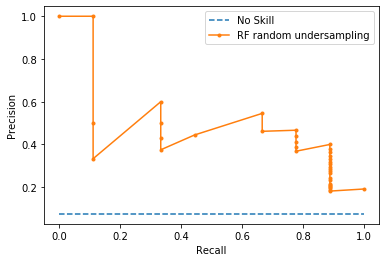

In [42]:
plot_pr_curve(y_test, pos_ppred)

In [43]:
# Saving the model
import pickle
pickle.dump(rfus, open('nobel_rfus.pkl', 'wb'))